In [ ]:
!unzip -q '/content/drive/MyDrive/Conglomerate Concrete Crack Detection.zip'

In [ ]:
import tensorflow as tf
import os

def load_image_mask(image_path, mask_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256,256))
  image = tf.cast(image, tf.float32)/255

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, (256,256))
  mask = tf.cast(mask, tf.float32)/255

  return image, mask

def augment(image, mask):
  if tf.random.uniform(())>0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

  if tf.random.uniform(())>0.5:
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)

  if tf.random.uniform(())>0.5:
    image = tf.image.random_brightness(image, max_delta=0.1)

  if tf.random.uniform(())>0.5:
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

  return image, mask

def create_dataset(image_paths, mask_paths, batch_size=16, augment_data=False):
  image_paths = sorted([os.path.join(image_paths, fname) for fname in os.listdir(image_paths)])
  mask_paths = sorted([os.path.join(mask_paths, fname)for fname in os.listdir(mask_paths)])

  dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
  dataset = dataset.map(load_image_mask, num_parallel_calls = tf.data.AUTOTUNE)

  if augment_data:
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

  dataset = dataset.shuffle(buffer_size=1000) if augment_data else dataset
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return  dataset


train_dataset = create_dataset(image_paths = '/content/Conglomerate Concrete Crack Detection/Train/images',
                               mask_paths = '/content/Conglomerate Concrete Crack Detection/Train/masks',
                               batch_size=16,
                               augment_data = True)

val_dataset = create_dataset(image_paths = '/content/Conglomerate Concrete Crack Detection/Test/images',
                             mask_paths = '/content/Conglomerate Concrete Crack Detection/Test/masks',
                             batch_size = 16, augment_data=False)

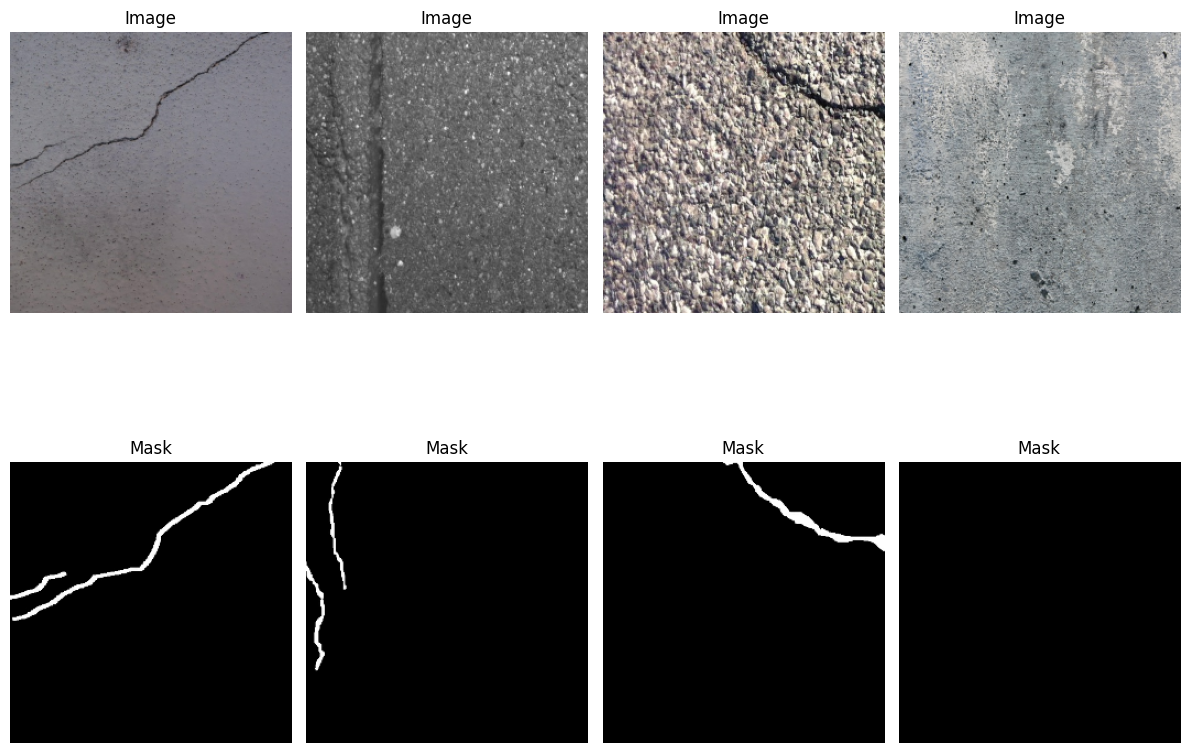

In [ ]:
import matplotlib.pyplot as plt
import random

image_dir = '/content/Conglomerate Concrete Crack Detection/Train/images'
mask_dir =  '/content/Conglomerate Concrete Crack Detection/Train/masks'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

idx = random.sample(range(len(image_paths)), 4)

plt.figure(figsize=(12, 10))
for i in range(len(idx)):
  img, msk = load_image_mask(image_paths[idx[i]], mask_paths[idx[i]])
  plt.subplot(2,4,i+1)
  plt.imshow(img)
  plt.title('Image')
  plt.axis('off')

  plt.subplot(2,4,i+5)
  plt.imshow(msk, cmap='gray')
  plt.title('Mask')
  plt.axis('off')

plt.tight_layout()

In [ ]:
def conv_block(inputs, num_filters):
  x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('leaky_relu')(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)

  x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('leaky_relu')(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)
  return x

def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  p = tf.keras.layers.MaxPool2D(2,2)(x)
  return x, p

def decoder_block(inputs, skip_features, num_filters):
  x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding= 'same')(inputs)
  x = tf.keras.layers.Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x


In [ ]:
def build_unet(input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)

  s1,p1 = encoder_block(inputs, 32)
  s2,p2 = encoder_block(p1, 64)
  s3,p3 = encoder_block(p2, 128)
  s4,p4 = encoder_block(p3, 256)

  b1 = conv_block(p4, 512)

  d1 = decoder_block(b1, s4, 256)
  d2 = decoder_block(d1, s3, 128)
  d3 = decoder_block(d2, s2, 64)
  d4 = decoder_block(d3, s1, 32)

  outputs= tf.keras.layers.Conv2D(1,1, padding='same', activation='sigmoid')(d4)
  model = tf.keras.models.Model(inputs, outputs, name = 'U-Net')
  return model

input_shape = (256, 256,3)
model = build_unet(input_shape)

In [ ]:
# model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(train_dataset, epochs=3, validation_data=val_dataset)

In [ ]:
def dice_loss(y_true,y_pred,smooth=1):
  y_true=tf.cast(y_true,tf.float32)
  y_pred=tf.cast(y_pred,tf.float32)

  intersection=tf.reduce_sum(y_true *y_pred)
  union=tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)

  dice=(2. * intersection +smooth)/ (union +smooth)
  return 1-dice



def bce_dice_loss(y_true,y_pred):
  bce=tf.keras.losses.BinaryCrossentropy()(y_true,y_pred)
  dice=dice_loss(y_true,y_pred)
  return bce+dice

def dice_coef(y_true,y_pred,smooth=1):
  y_true=tf.cast(y_true,tf.float32)
  y_pred=tf.cast(y_pred>0.5,tf.float32)

  intersection=tf.reduce_sum(y_true*y_pred)
  union=tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)

  dice=(2 *intersection+smooth)/(union+smooth)
  return dice

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=bce_dice_loss, metrics = [dice_coef])
model.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
619/619 ━━━━━━━━━━━━━━━━━━━━ 342s 447ms/step - dice_coef: 0.2302 - loss: 1.4661 - val_dice_coef: 0.1305 - val_loss: 1.1719
Epoch 2/2
619/619 ━━━━━━━━━━━━━━━━━━━━ 230s 367ms/step - dice_coef: 0.3393 - loss: 1.0882 - val_dice_coef: 0.0485 - val_loss: 1.1079


In [ ]:
def visualize_overlay_samples(image_dir, mask_dir, num_samples=5, alpha=0.8):
  image_paths = sorted([os.path.join(image_dir,fname) for fname in os.listdir(image_dir)])
  mask_paths = sorted([os.path.joins(mask_dir, fname) for fname in os.listdir(mask_dir)])

  sample_indices = random.sample(range(len(image_paths)), num_samples)

  plt.figure(figsize=(8, num_samples*3))

  for i, idx in enumerate(sample_indices):
    img, msk = load_image_mask(image_paths[idx], mask_paths[idx])

    img = img.numpy()
    msk = msk.numpy()

    msk_rgb = tf.concat([msk,msk,msk], axis=-1).numpy()

    overlay = img.copy()
    overlay[msk_rgb[:,:,0]>0.5]=[1.0, 0,0]

    blended = (1-alpha)*img+alpha*overlay

    plt.subplot(num_samples, 1,i+1)
    plt.imshow(blended)
    plt.title(f'Image{idx} with Mask Overlay')
    plt.axis('off')

  plt.tight_layout()
  plt.show()



In [ ]:
def visualize_predictions(model, image_dir, mask_dir, num_samples=5, alpha=0.4):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    sample_indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(8, num_samples * 3))

    for i, idx in enumerate(sample_indices):
        # Load image and mask
        img, msk = load_image_mask(image_paths[idx], mask_paths[idx])

        # Get the model prediction (pred mask)
        pred_mask = model.predict(tf.expand_dims(img, axis=0))[0]

        # Prepare the masks and image
        img = img.numpy()
        msk = msk.numpy()

        # Convert mask to RGB for overlay
        msk_rgb = tf.concat([msk, msk, msk], axis=-1).numpy()  # Ensure msk_rgb has 3 channels
        pred_rgb = tf.concat([pred_mask, pred_mask, pred_mask], axis=-1)  # Predicted mask as RGB

        # Overlay: Image + (Ground truth mask * color)
        gt_overlay = img.copy()
        # Change here: Assign to all 3 color channels
        gt_overlay[msk_rgb[:,:,0] > 0.5] = [1.0, 0, 0]  # Red color where mask is 1

        # Overlay: Image + (Predicted mask * color)
        pred_overlay = img.copy()
        # Change here: Assign to all 3 color channels
        pred_overlay[pred_rgb[:,:,0] > 0.5] = [0, 1.0, 0]  # Green color where predicted mask is 1

        # Blended (actual ground truth overlay)
        blended_gt = (1 - alpha) * img + alpha * gt_overlay

        # Blended (predicted mask overlay)
        blended_pred = (1 - alpha) * img + alpha * pred_overlay

        # Display ground truth and predicted mask overlays
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(blended_gt)
        plt.title(f"Ground Truth {idx}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(blended_pred)
        plt.title(f"Prediction {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


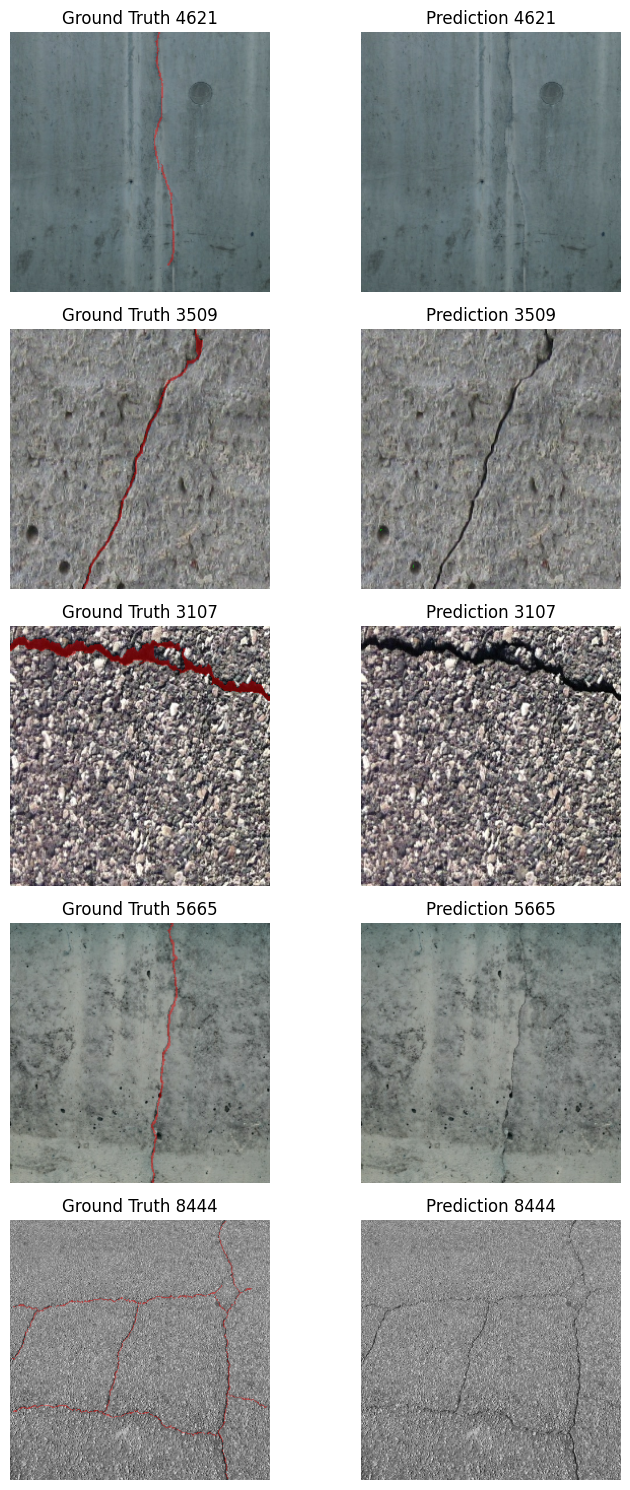

In [ ]:
visualize_predictions(
    model=model,  # Your trained model
    image_dir='/content/Conglomerate Concrete Crack Detection/Train/images',
    mask_dir='/content/Conglomerate Concrete Crack Detection/Train/masks',
    num_samples=5)